In [43]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score, make_scorer
from sklearn.model_selection import cross_val_score, train_test_split, StratifiedKFold
from xgboost import XGBClassifier
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import pandas as pd
import numpy as np

In [44]:
DATA_DIR = "../data"
MODEL_DIR = "../models"

In [45]:
df = pd.read_csv(f"{DATA_DIR}/pima-indians-diabetes.csv")
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


## 1. EDA

In [46]:
df.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885,0.348958
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


In [47]:
df.shape

(768, 9)

In [48]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


In [49]:
print(f"Are there any null values?: {df.isnull().values.any()}")
print(f"Number of duplicated values: {df.duplicated().sum()}")

Are there any null values?: False
Number of duplicated values: 0


In [50]:
# Columns
columns = df.columns.to_list()
print("Columns:", end=" ")
print(*columns, sep=", ")

Columns: Pregnancies, Glucose, BloodPressure, SkinThickness, Insulin, BMI, DiabetesPedigreeFunction, Age, Outcome


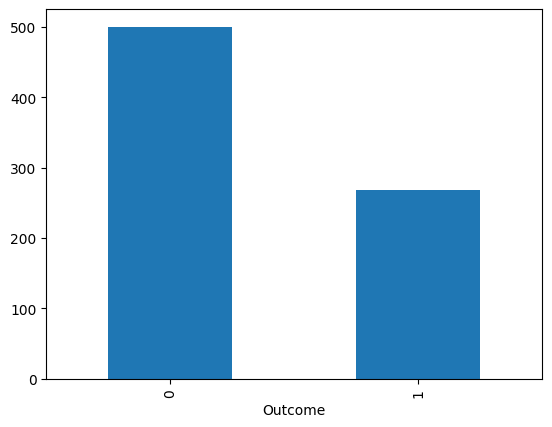

In [51]:
# Inspect target column
df["Outcome"].value_counts().plot.bar()
plt.show()

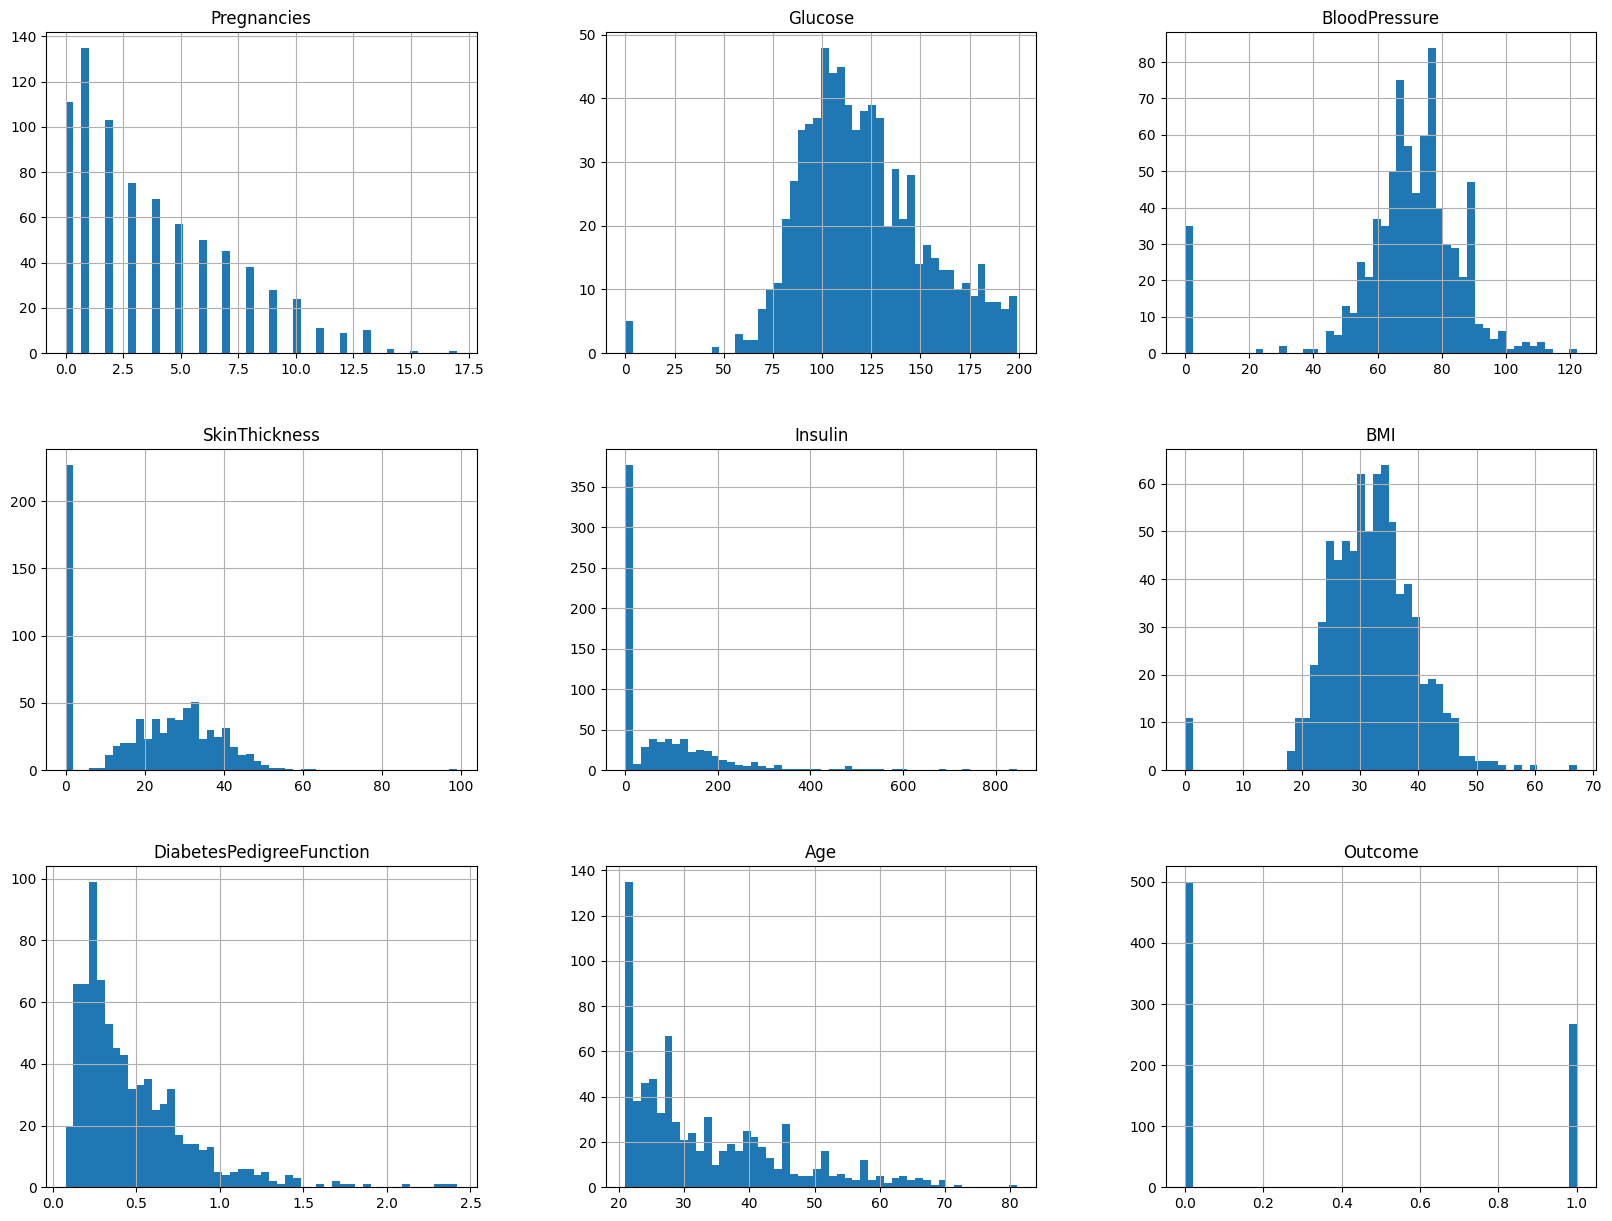

In [52]:
%matplotlib inline
df.hist(bins=50, figsize=(20, 15))
plt.show()

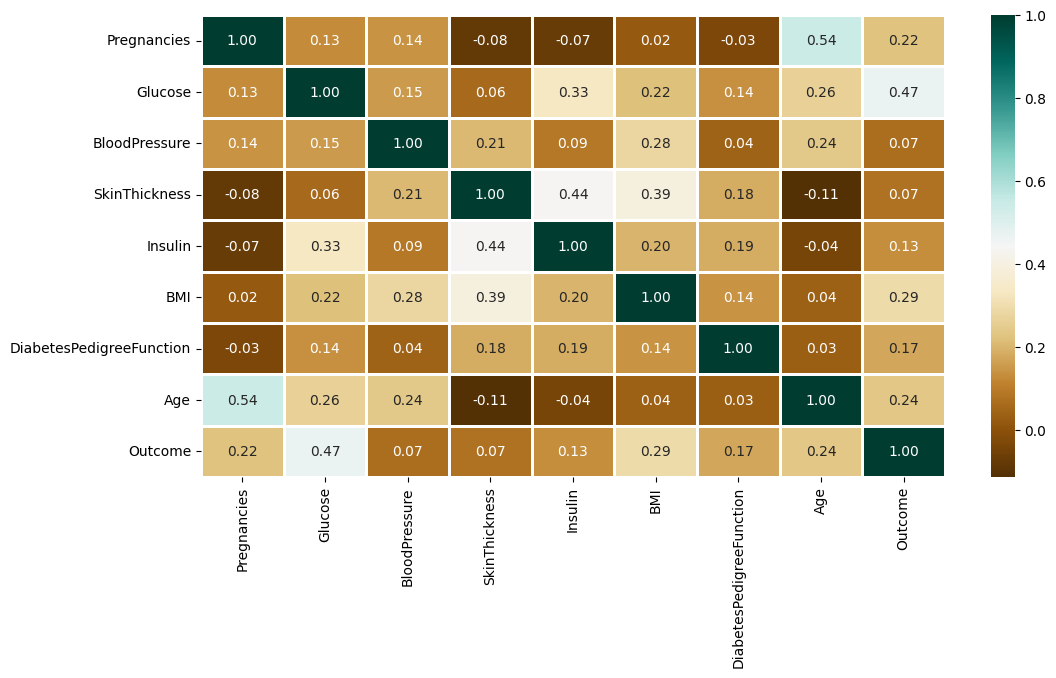

In [53]:
plt.figure(figsize=(12, 6))
sns.heatmap(df.corr(), cmap='BrBG', fmt='.2f', linewidths=2, annot=True)
plt.show()

## 2. Data Processing

In [54]:
y = df["Outcome"]
X = df[columns[:-1]]

In [55]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Data train: X_train shape {X_train.shape}, y_train shape {y_train.shape}")
print(f"Data test: X_test shape {X_test.shape}, y_test shape {y_test.shape}")

Data train: X_train shape (614, 8), y_train shape (614,)
Data test: X_test shape (154, 8), y_test shape (154,)


## 3. Modeling

In [56]:
def calculate_metrics(y_true, y_pred):
    # Metrics used to evaluate models
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    return accuracy, precision, recall, f1

In [68]:
def display_metrics(accuracy, precision, recall, f1):
    print(f"Accuracy: {accuracy:.5f}")
    print(f"Precision: {precision:.5f}")
    print(f"Recall: {recall:.5f}")
    print(f"F1-Score: {f1:.5f}")

In [69]:
def train(model, X: pd.DataFrame, y: pd.DataFrame) -> dict:
    skfolds = StratifiedKFold(n_splits=6, shuffle=True, random_state=42)
    scores = {
        "accuracy": [],
        "precision": [],
        "recall": [],
        "f1-score": []
    }
    count = 0
    for train_idx, val_idx in skfolds.split(X, y):
        X_train_folds = X.iloc[train_idx, :]
        X_val_folds = X.iloc[val_idx, :]
        y_train_folds = y.iloc[train_idx]
        y_val_folds = y.iloc[val_idx]
        model.fit(X_train_folds, y_train_folds)
        y_pred = model.predict(X_val_folds)
        accuracy, precision, recall, f1 = calculate_metrics(y_val_folds, y_pred)
        scores["accuracy"].append(accuracy)
        scores["precision"].append(precision)
        scores["recall"].append(recall)
        scores["f1-score"].append(f1)
        count += 1
    
    mean_accuracy = np.mean(scores["accuracy"])
    mean_precision = np.mean(scores["precision"])
    mean_recall = np.mean(scores["recall"])
    mean_f1 = np.mean(scores["f1-score"])
    
    return mean_accuracy, mean_precision, mean_recall, mean_f1

In [70]:
model = XGBClassifier()
mean_accuracy, mean_precision, mean_recall, mean_f1 = train(model, X_train, y_train)
display_metrics(mean_accuracy, mean_precision, mean_recall, mean_f1)

Accuracy: 0.72474
Precision: 0.60532
Recall: 0.59048
F1-Score: 0.59631


## 4. Prepare for deployment

In [71]:
joblib.dump(model, f'{MODEL_DIR}/model.pkl')

['../models/model.pkl']

In [72]:
clf = joblib.load(f'{MODEL_DIR}/model.pkl')
y_pred = clf.predict(X_test)
test_metrics = calculate_metrics(y_test, y_pred)
display_metrics(*test_metrics)

Accuracy: 0.67532
Precision: 0.53968
Recall: 0.61818
F1-Score: 0.57627
